# Plan

* organizar preprocesamiento
 * corregir fecha TRM
* Dejar Solo funciones
* programar ciclos
* dejar registro quiebras
* dejar registro cuantos quiebran y sobreviven
* analizar resultados en otro script
 * hurst
 * ley potencia
* probar con nuevo resultado
* probar con otro indice
* fin


# Librerías y configuraciones generales

In [1]:
import pandas as pd
from random import randrange
import random
import math
from statsmodels.tsa.api import SimpleExpSmoothing
import matplotlib.pyplot as plt
import warnings

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Preprocesamiento 
* Carga datos de entrada

In [4]:
rango_lectura=['2020-10-09','2021-05-18']
rango_indice=['2020-09-09','2021-05-18']

In [5]:
base_rss = pd.read_csv (r'TranformacionBases_Java/Rss_adap_multi.csv', engine='python', encoding = "ISO-8859-1", sep=';')
base_twitter = pd.read_csv (r'TranformacionBases_Java/Twitter_adap_multi.csv', engine='python', encoding = "ISO-8859-1", sep=';')

In [6]:
# rangos datos lecturas
print("rango rss: min: ",min(base_rss['date_adj']), " max: ",max(base_rss['date_adj']))
print("rango twitter: min: ",min(base_twitter['date']), " max: ",max(base_twitter['date']))

rango rss: min:  2020-10-09  max:  2021-05-18
rango twitter: min:  2020-10-05  max:  2021-05-30


In [7]:
datos_twitter=base_twitter[['id_fuente','date','polaridad']].groupby(['id_fuente','date']).mean().reset_index()
#datos_twitter

In [8]:
datos_twitter['date'] = pd.to_datetime(datos_twitter['date']).dt.date

In [9]:
datos_rss=base_rss[['fuenteRss','date','polaridad']].groupby(['fuenteRss','date']).mean().reset_index()
#datos_rss

In [10]:
datos_rss['date'] = pd.to_datetime(datos_rss['date']).dt.date

### Eliminar dias sin lecturas

In [11]:
## empezar desde el 9 de octubre

In [12]:
val_twitter=datos_twitter[['date','id_fuente']].groupby('date').count()

In [13]:
#val_twitter[val_twitter['id_fuente']<val_twitter['id_fuente'].mean()-(val_twitter['id_fuente'].std())*1.64]

In [14]:
val_rss=datos_rss[['date','fuenteRss']].groupby('date').count()
#val_rss

In [15]:
#val_rss[val_rss['fuenteRss']<val_rss['fuenteRss'].mean()-(val_rss['fuenteRss'].std())*1.7]

In [16]:
## fin validacion rss

In [17]:
fechas_quitar=list(val_twitter[val_twitter['id_fuente']<val_twitter['id_fuente'].mean()-(val_twitter['id_fuente'].std())*1.64].index)

In [18]:
fechas_quitar=fechas_quitar+list(val_rss[val_rss['fuenteRss']<val_rss['fuenteRss'].mean()-(val_rss['fuenteRss'].std())*1.7].index)

In [19]:
fechas_quitar

[datetime.date(2020, 10, 5),
 datetime.date(2020, 10, 6),
 datetime.date(2020, 10, 7),
 datetime.date(2020, 10, 8),
 datetime.date(2020, 10, 21),
 datetime.date(2020, 10, 22),
 datetime.date(2020, 10, 23),
 datetime.date(2020, 10, 24),
 datetime.date(2021, 1, 9),
 datetime.date(2021, 3, 19),
 datetime.date(2021, 4, 28),
 datetime.date(2021, 5, 21),
 datetime.date(2020, 10, 13),
 datetime.date(2020, 10, 14),
 datetime.date(2020, 10, 15),
 datetime.date(2020, 10, 16),
 datetime.date(2020, 10, 17),
 datetime.date(2020, 10, 18),
 datetime.date(2020, 10, 19),
 datetime.date(2020, 10, 20),
 datetime.date(2020, 10, 21),
 datetime.date(2020, 10, 22),
 datetime.date(2020, 10, 23),
 datetime.date(2020, 10, 24),
 datetime.date(2020, 12, 10),
 datetime.date(2021, 5, 18),
 datetime.date(2021, 9, 1),
 datetime.date(2021, 10, 1)]

In [20]:
## eliminar duplicados

In [21]:
fechas_quitar = list(dict.fromkeys(fechas_quitar))

In [22]:
##igualar rangos

In [23]:
datos_trm=pd.read_csv (r'TranformacionBases_Java/TRM_total_adap_multi.csv', engine='python', encoding = "ISO-8859-1", sep=';')

In [24]:
datos_trm=datos_trm[datos_trm['date']>=rango_indice[0]]
datos_trm=datos_trm[datos_trm['date']<=rango_indice[1]]

In [25]:
datos_trm

,Fecha,fecha operación,TRM,Diferencia,Dia sem,nom Dia Sem,fin Semana,Dif Cero,date_operacion,date
10514,9/9/2020,8/9/2020,3757.21,54.59,3,mar,0,0,2020-09-08,2020-09-09
10515,10/9/2020,9/9/2020,3717.25,-39.96,4,mié,0,0,2020-09-09,2020-09-10
10516,11/9/2020,10/9/2020,3700.28,-16.97,5,jue,0,0,2020-09-10,2020-09-11
10517,12/9/2020,11/9/2020,3709.00,8.72,6,vie,0,0,2020-09-11,2020-09-12
10518,13/9/2020,12/9/2020,3709.00,0.00,7,sáb,1,1,2020-09-12,2020-09-13
...,...,...,...,...,...,...,...,...,...,...
10761,14/5/2021,13/5/2021,3728.09,-6.00,5,jue,0,0,2021-05-13,2021-05-14
10762,15/5/2021,14/5/2021,3682.84,-45.25,6,vie,0,0,2021-05-14,2021-05-15
10763,16/5/2021,15/5/2021,3682.84,0.00,7,sáb,1,1,2021-05-15,2021-05-16
10764,17/5/2021,16/5/2021,3682.84,0.00,1,dom,1,1,2021-05-16,2021-05-17


In [26]:
datos_trm['date'] = pd.to_datetime(datos_trm['date']).dt.date

In [27]:
datos_twitter.columns=['fuente','date','polaridad']
datos_rss.columns=['fuente','date','polaridad']

In [28]:
#datos_rss

In [29]:
datos_lectura=datos_twitter.append(datos_rss)

In [30]:
#datos_lectura

In [31]:
pd.to_datetime(rango_lectura[0]).date()

datetime.date(2020, 10, 9)

In [32]:
#datos_lectura=datos_lectura[datos_lectura['date']>=rango_lectura[0]]
#datos_lectura=datos_lectura[datos_lectura['date']<=rango_lectura[1]]
datos_lectura=datos_lectura[datos_lectura['date']>=pd.to_datetime(rango_lectura[0]).date()]
datos_lectura=datos_lectura[datos_lectura['date']<=pd.to_datetime(rango_lectura[1]).date()]

In [33]:
datos_lectura=datos_lectura[datos_lectura['polaridad']!=0]

In [34]:
datos_lectura

,fuente,date,polaridad
0,BluRadioCo,2020-10-09,-0.347026
1,BluRadioCo,2020-10-10,-0.271511
2,BluRadioCo,2020-10-11,-0.635847
3,BluRadioCo,2020-10-25,-0.249044
4,BluRadioCo,2020-10-26,-0.410109
...,...,...,...
109898,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.719400
109899,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.960484
109900,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.977641
109901,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.882855


## Carga Maestro Fuentes

In [35]:
base_maestro_fuentes = pd.read_csv (r'TranformacionBases_Java/maestro_fuentes.csv', engine='python', encoding = "ISO-8859-1", sep=';')

In [36]:
base_maestro_fuentes.reset_index()

,index,fuente,tipo
0,0,http://elnacional.com.do/feed/,rss
1,1,http://ep00.epimg.net/rss/economia/portada.xml,rss
2,2,http://ep00.epimg.net/rss/tags/ultimas_noticia...,rss
3,3,http://feeds.nytimes.com/nyt/rss/Business,rss
4,4,http://feeds.nytimes.com/nyt/rss/Technology,rss
...,...,...,...
132,132,elcolombiano,twitter
133,133,elespectador,twitter
134,134,lafm,twitter
135,135,rcnmundo,twitter


In [37]:
datos_lectura=datos_lectura.merge(base_maestro_fuentes.reset_index(), left_on='fuente', right_on='fuente', how='left')
datos_lectura

,fuente,date,polaridad,index,tipo
0,BluRadioCo,2020-10-09,-0.347026,118,twitter
1,BluRadioCo,2020-10-10,-0.271511,118,twitter
2,BluRadioCo,2020-10-11,-0.635847,118,twitter
3,BluRadioCo,2020-10-25,-0.249044,118,twitter
4,BluRadioCo,2020-10-26,-0.410109,118,twitter
...,...,...,...,...,...
78606,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.719400,117,rss
78607,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.960484,117,rss
78608,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.977641,117,rss
78609,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.882855,117,rss


In [38]:
datos_lectura

,fuente,date,polaridad,index,tipo
0,BluRadioCo,2020-10-09,-0.347026,118,twitter
1,BluRadioCo,2020-10-10,-0.271511,118,twitter
2,BluRadioCo,2020-10-11,-0.635847,118,twitter
3,BluRadioCo,2020-10-25,-0.249044,118,twitter
4,BluRadioCo,2020-10-26,-0.410109,118,twitter
...,...,...,...,...,...
78606,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.719400,117,rss
78607,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.960484,117,rss
78608,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.977641,117,rss
78609,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.882855,117,rss


## Calendario

In [39]:
calendario = pd.DataFrame({"Date": pd.date_range(rango_indice[0], rango_indice[1])})

In [40]:
calendario

,Date
0,2020-09-09
1,2020-09-10
2,2020-09-11
3,2020-09-12
4,2020-09-13
...,...
247,2021-05-14
248,2021-05-15
249,2021-05-16
250,2021-05-17


In [41]:
### remover dias seleccionados
fechas_quitar

[datetime.date(2020, 10, 5),
 datetime.date(2020, 10, 6),
 datetime.date(2020, 10, 7),
 datetime.date(2020, 10, 8),
 datetime.date(2020, 10, 21),
 datetime.date(2020, 10, 22),
 datetime.date(2020, 10, 23),
 datetime.date(2020, 10, 24),
 datetime.date(2021, 1, 9),
 datetime.date(2021, 3, 19),
 datetime.date(2021, 4, 28),
 datetime.date(2021, 5, 21),
 datetime.date(2020, 10, 13),
 datetime.date(2020, 10, 14),
 datetime.date(2020, 10, 15),
 datetime.date(2020, 10, 16),
 datetime.date(2020, 10, 17),
 datetime.date(2020, 10, 18),
 datetime.date(2020, 10, 19),
 datetime.date(2020, 10, 20),
 datetime.date(2020, 12, 10),
 datetime.date(2021, 5, 18),
 datetime.date(2021, 9, 1),
 datetime.date(2021, 10, 1)]

In [42]:
calendario=calendario[~calendario['Date'].isin(fechas_quitar)]

In [43]:
calendario=calendario.reset_index(drop=True)

In [44]:
calendario

,Date
0,2020-09-09
1,2020-09-10
2,2020-09-11
3,2020-09-12
4,2020-09-13
...,...
226,2021-05-13
227,2021-05-14
228,2021-05-15
229,2021-05-16


In [45]:
calendario['Date']=pd.to_datetime(calendario['Date']).dt.date

# Agente

In [46]:
def crearAgente(id,tipo): #quizas falta el valor del var econ,
    agente={}
    agente['TIPO']=tipo
    agente['id']=id
    agente['edad']=0
    agente['capital']= randrange(1000,1000000000)
    agente['stockProducto']=randrange(10,1000000)
    agente['umbralStock']=randrange(10,1000000) ##no agregado al modelo
    agente['habilidadAdministrativa']=random.uniform(-0.02, 0.5)
    #agente['tasaConsumo']=random.uniform(0.1, 0.5)
    if agente['TIPO']=='Comprador':
        agente['rentabilidad']=random.uniform(0.1, 0.2)
    elif agente['TIPO']=='Vendedor':
        agente['rentabilidad']=random.uniform(0.1, 0.2)
    agente['tamanoRegresion']= randrange(5,20)
    # perfilIntereses  No aplica
    agente['impactoTextos']=random.uniform(-1, 1)
    agente['estrategiaLectura']=[0]*NUM_FUENTES_INTERPRETACION
    agente['estrategiaLectura_imp']=[0]*NUM_FUENTES_INTERPRETACION
    for i in range(NUM_FUENTES_INTERPRETACION):
        agente['estrategiaLectura'][i]=randrange(NUM_FUENTES_TOTATALES)
        agente['estrategiaLectura_imp'][i]=random.random()
    agente['numeroDiasLecturas']=randrange(2,7)
    agente['umbralPronostico']=random.uniform(0.2, 0.5)
    agente['porcentajeCapitalCompra']=random.uniform(0, 1)
    agente['porcentajeStockVenta']=random.uniform(0, 1)
    #agente['costoMauc']  costo del commoditie según bolsa
    #agente['costosFijos']=random.uniform(0.1, 0.3)
    agente['tasaProduccion']=random.uniform(0, 0.5)
    #agente['limiteSobrePrecio']=random.uniform(0.01, 0.3)
    agente['viveza']=random.uniform(0.3, 1)
    #agente['vivezaVendedor']=random.uniform(0.05, 0.2)    
    agente['controlGastosEImpuestos']=random.uniform(0.1, 0.3)
    
    agentesCreados.append(agente)
    return agente

In [47]:
def pronosticoAgente(agente):    
    reg_inicio=FECHA_PULSO-agente['tamanoRegresion']
    rango_reg_agente=[calendario.iloc[reg_inicio]['Date'],calendario.iloc[FECHA_PULSO]['Date']]

    serie_indice_agente=datos_trm[datos_trm['date']>=rango_reg_agente[0]]
    serie_indice_agente=serie_indice_agente[serie_indice_agente['date']<=rango_reg_agente[1]]

    modelo_agente=SimpleExpSmoothing(serie_indice_agente['TRM']).fit(smoothing_level=0.8,optimized=False)
    prediccion_base_agente=modelo_agente.forecast()

    prediccion_base_agente=prediccion_base_agente.values[0]
    df_lecura_agente=pd.DataFrame({'index':agente['estrategiaLectura'] , 'impacto': agente['estrategiaLectura_imp']})

    lect_inicio=FECHA_PULSO-agente['numeroDiasLecturas']
    rango_lec_agente=[calendario.iloc[lect_inicio]['Date'],calendario.iloc[FECHA_PULSO]['Date']]

    serie_lectura_agente=datos_lectura[datos_lectura['date']>=rango_lec_agente[0]]
    serie_lectura_agente=serie_lectura_agente[serie_lectura_agente['date']<=rango_lec_agente[1]]
    serie_lectura_agente=serie_lectura_agente.merge(df_lecura_agente, left_on='index', right_on='index', how='left')

    serie_lectura_agente=serie_lectura_agente[serie_lectura_agente['impacto'].notnull()]
    serie_lectura_agente['factor']=serie_lectura_agente['polaridad']*serie_lectura_agente['impacto']
    
    #agente['pronosticos_dia_siguiente']=prediccion_base_agente*(1+serie_lectura_agente['factor'].mean()*agente['impactoTextos'])
    if len(serie_lectura_agente)>0 :
        #agente['pronosticos_dia_siguiente']=prediccion_base_agente*(1+serie_lectura_agente['factor'].mean()*agente['impactoTextos'])
        pronosticos_dia_siguiente=prediccion_base_agente*(1+serie_lectura_agente['factor'].mean()*agente['impactoTextos'])
    else:
        #agente['pronosticos_dia_siguiente']=prediccion_base_agente
        pronosticos_dia_siguiente=prediccion_base_agente
        
    return pronosticos_dia_siguiente

In [48]:
def activacionComprador(agente):
    #cuando
    agente['activo']=False
    #necesita stock?
    val_stock=agente['stockProducto']<agente['umbralStock']
    #el cambio del mercado le combiene?  prediccion - valor actual
    val_conveniencia=(agente['pronosticos_dia_siguiente'] - VALOR_MOMENTO_INDICE) > agente['umbralPronostico']*VALOR_MOMENTO_INDICE
    #alguna de las 2 situaciones
    agente['activo']=val_stock or val_conveniencia
    #cuanto comprar
    agente['cantidadTransaccionar']=agente['capital']*agente['porcentajeCapitalCompra']/VALOR_MOMENTO_INDICE ## revisar
    #precio negociacion
       
    #agente['precioNegociacion']=(agente['pronosticos_dia_siguiente'] - VALOR_MOMENTO_INDICE)*(1-agente['viveza'])+VALOR_MOMENTO_INDICE
    agente['precioNegociacion']=abs(agente['pronosticos_dia_siguiente'] - VALOR_MOMENTO_INDICE)*(1-agente['viveza'])+min(VALOR_MOMENTO_INDICE,agente['pronosticos_dia_siguiente'])
    
    return agente['activo']

In [49]:
def activacionVendedor(agente):
    #cuando vender
    agente['activo']=False
    #necesita stock?
    val_stock=agente['stockProducto']>agente['umbralStock']
    #el cambio del mercado le combiene?  prediccion - valor actual
    val_conveniencia=(VALOR_MOMENTO_INDICE - agente['pronosticos_dia_siguiente'] ) > agente['umbralPronostico']*VALOR_MOMENTO_INDICE
    #alguna de las 2 situaciones
    agente['activo']=val_stock or val_conveniencia
    #cuanto vender
    agente['cantidadTransaccionar']=agente['stockProducto']*agente['porcentajeStockVenta']
    #precio negociacion
    #agente['precioNegociacion']=(agente['pronosticos_dia_siguiente'] - VALOR_MOMENTO_INDICE)*(1+agente['vivezaVendedor'])+VALOR_MOMENTO_INDICE
    agente['precioNegociacion']=abs(agente['pronosticos_dia_siguiente'] - VALOR_MOMENTO_INDICE)*(agente['viveza'])+min(VALOR_MOMENTO_INDICE,agente['pronosticos_dia_siguiente'])    
    # los vendedores tienen la rentabilidad en le precio de negociación
    #agente['precioNegociacion']=agente['precioNegociacion']/(1-agente['rentabilidad'])
    
    return agente['activo']

In [50]:
def transaccionarAgente(agenteComprador,agenteVendedor):
    #id agentes
    idComprador=agenteComprador.get('id')
    idVendedor=agenteVendedor.get('id')    
    #definir cantidad transaccionar
    cantidadRequeridaComprador=agenteComprador['cantidadTransaccionar']
    cantidadDisponibleVendedor=agenteVendedor['cantidadTransaccionar']
    cantidadTransaccion= cantidadRequeridaComprador if cantidadRequeridaComprador<cantidadDisponibleVendedor else cantidadDisponibleVendedor
    #precio transaccion
    precioTransaccion=agenteVendedor['precioNegociacion']
    #comision=precioTransaccion*0.05
    #numeroPulsoActual
    #FECHA_PULSO
    
    #Cambio estado agentes
    #comprador
    agenteComprador['capital']=agenteComprador['capital']-precioTransaccion*(1.05)*cantidadTransaccion  #incluye comision
    ##sin costo mauc
    agenteComprador['stockProducto']=agenteComprador['stockProducto']+cantidadTransaccion
    agenteComprador['cantidadTransaccionar']=agenteComprador['cantidadTransaccionar']-cantidadTransaccion
    #vendedor
    agenteVendedor['capital']=agenteVendedor['capital']+precioTransaccion*(1.05)*cantidadTransaccion
    agenteVendedor['stockProducto']=agenteVendedor['stockProducto']-cantidadTransaccion
    agenteVendedor['cantidadTransaccionar']=agenteVendedor['cantidadTransaccionar']-cantidadTransaccion
    #validar activacion agentes, retornar para acciones
    desactivarComprador=agenteComprador['cantidadTransaccionar']==0
    desactivarVendedor=agenteVendedor['cantidadTransaccionar']==0
    lineaTransaccion=[idComprador,idVendedor,cantidadTransaccion,precioTransaccion,FECHA_PULSO,CICLO]
    #lineaTransaccion=[idComprador,idVendedor,cantidadTransaccion,precioTransaccion,FECHA_PULSO]
    #return {'desact_comp':desactivarComprador, 'desact_vend':desactivarVendedor, 'lineaTransaccion':lineaTransaccion}
    return [desactivarComprador, desactivarVendedor, lineaTransaccion]

In [51]:
def vivirComprador(agente):
    #aprovecha unidades
    unidadesAprovechadas=agente['habilidadAdministrativa']*agente['stockProducto']
    agente['stockProducto']=agente['stockProducto']-unidadesAprovechadas
    #tiene gastos
    agente['capital']=agente['capital']*(1-agente['controlGastosEImpuestos'])
    #recibe capital
    precioAprovechamiento=VALOR_MOMENTO_INDICE/(1-agente['rentabilidad'])
    agente['capital']=agente['capital']+unidadesAprovechadas*precioAprovechamiento
    #reevaluar costos fijos 
    #aumentar edad
    agente['edad']=agente['edad']+1

In [52]:
def vivirVendedor(agente):
    #tiene gastos
    agente['capital']=agente['capital']*(1-agente['controlGastosEImpuestos'])
    #le cuesta producir
    agente['capital']=agente['capital']*(1-agente['habilidadAdministrativa'])*agente['tasaProduccion']
    #aumenta el stock con lo producido
    agente['stockProducto']=agente['stockProducto']+agente['stockProducto']*agente['tasaProduccion']
    #aumenta edad
    agente['edad']=agente['edad']+1

# Universo

In [53]:
#GENERACION ESPONTANEA UNIVERSO
def generacionEspontanea():     
    global NUMERO_ACUMULADO_AGENTES
    for i in range(POBLACION_INICIAL):
        NUMERO_ACUMULADO_AGENTES=NUMERO_ACUMULADO_AGENTES+1
        if(random.random()<=CANT_COMPRADORES):            
            compradores.append(crearAgente(NUMERO_ACUMULADO_AGENTES,'Comprador'))
        else:
            vendedores.append(crearAgente(NUMERO_ACUMULADO_AGENTES,'Vendedor'))

In [54]:
def quiebraEmpresas():
    #quiebraEmpresas    
    for comp in compradores:
        capiltalEmpresa=comp['capital']
        valorStockEmpresa=comp['stockProducto']*VALOR_MOMENTO_INDICE
        valorEmpresa=capiltalEmpresa+valorStockEmpresa        
        #print("COMP capemp:",capiltalEmpresa,' valemp:',valorEmpresa, ' limQuiebra:',LIMITE_QUIEBRA)
        if capiltalEmpresa<LIMITE_QUIEBRA or valorEmpresa<LIMITE_QUIEBRA :
            #print("entraComp")
            compradores.remove(comp)     
            agentesQuebrados.append(comp)
    for vend in vendedores:
        capiltalEmpresa=vend['capital']
        valorStockEmpresa=vend['stockProducto']*VALOR_MOMENTO_INDICE
        valorEmpresa=capiltalEmpresa+valorStockEmpresa        
        #print("VEND capemp:",capiltalEmpresa,' valemp:',valorEmpresa, ' limQuiebra:',LIMITE_QUIEBRA)
        if capiltalEmpresa<LIMITE_QUIEBRA or valorEmpresa<LIMITE_QUIEBRA :
            #print("entraVend")
            vendedores.remove(vend)
            agentesQuebrados.append(vend)

In [55]:
def nuevosAgentes():
    global NUMERO_ACUMULADO_AGENTES
    #num_nuevos_agentes=math.floor(random.uniform(0, MAX_GENERACION_AGENTES)*POBLACION_ACTUAL)
    num_nuevos_agentes=math.floor(random.uniform(0, MAX_GENERACION_AGENTES)*POBLACION_ACTUAL)
    print("max_generacion_agentes: ",MAX_GENERACION_AGENTES,"nuevos Agentes: ", num_nuevos_agentes, "pob actual: ",POBLACION_ACTUAL, "pob final: ",POBLACION_ACTUAL+num_nuevos_agentes)
    for i in range(POBLACION_ACTUAL,POBLACION_ACTUAL+num_nuevos_agentes):
        NUMERO_ACUMULADO_AGENTES=NUMERO_ACUMULADO_AGENTES+1
        if(random.random()<=CANT_COMPRADORES):
            compradores.append(crearAgente(NUMERO_ACUMULADO_AGENTES,'Comprador'))
        else:
            vendedores.append(crearAgente(NUMERO_ACUMULADO_AGENTES,'Vendedor'))
        #guardar en lista de agentes creados

In [56]:
def pronosticoUniverso():
    for comp in compradores:
        #print(pronosticoAgente(comp))
        comp['pronosticos_dia_siguiente']=pronosticoAgente(comp)
    for vend in vendedores:
        #print(pronosticoAgente(vend))
        vend['pronosticos_dia_siguiente']=pronosticoAgente(vend)

In [57]:
def activacionUniverso():
    for comp in compradores:
        #print(pronosticoAgente(comp))
        auxActivacion=activacionComprador(comp)
        if auxActivacion:
            compradoresActivos.append(comp)
    for vend in vendedores:
        #print(pronosticoAgente(vend))
        auxActivacion=activacionVendedor(vend)
        if auxActivacion:
            vendedoresActivos.append(vend)

In [58]:
### Función transaccionar
def transaccionarUniverso():
    random.shuffle(compradoresActivos)
    
    while (len(compradoresActivos)>0 and len(vendedoresActivos)>0):
        for comp in compradoresActivos:     
            if len(vendedoresActivos)==0:
                #print("no hay vendedores")
                break

            df_ofertas=pd.DataFrame.from_dict(vendedoresActivos).sort_values('precioNegociacion')
            mejorVendedor=next(item for item in vendedoresActivos if item['id'] == df_ofertas.iloc[0]['id'])
            compradorMomento=comp

            precioMaximoCompra=compradorMomento['precioNegociacion']
            precioMinimoVenta=mejorVendedor['precioNegociacion']
            #selecciona si puede transaccionar
            if precioMaximoCompra>precioMinimoVenta:
                #print("transaccionar")
                #puede desactivar algun vendedor, antes de pasar a las siguientes transacciones
                (desactivarComprador, desactivarVendedor, lineaTransaccion)=transaccionarAgente(compradorMomento,mejorVendedor)
                #agregar transaccion a arreglo de transacciones con datos principales
                if desactivarComprador:
                    compradoresActivos.remove(compradorMomento)
                if desactivarVendedor:
                    vendedoresActivos.remove(mejorVendedor) 
                #registra la transacción
                DF_TRANSACCIONES.loc[len(DF_TRANSACCIONES)]=lineaTransaccion
            else :
                compradoresActivos.remove(compradorMomento)

In [59]:
def vivirUniverso():
    for comp in compradores:
        vivirComprador(comp)
    for vend in vendedores:
        vivirVendedor(vend)

# SIMULACION

## Parametros Globales

In [60]:
#AGENTES
NUM_FUENTES_TOTATALES=137
NUM_FUENTES_INTERPRETACION=5

In [61]:
#UNIVERSO
#POBLACION_INICIAL=50
POBLACION_INICIAL=100
CANT_COMPRADORES=0.6

#LIMITE_QUIEBRA=1000
LIMITE_QUIEBRA=10000000
#MAX_GENERACION_AGENTES=0.02
MAX_GENERACION_AGENTES=0.05

POBLACION_ACTUAL=0

In [62]:
FECHA_INICIAL_PULSO=36
FECHA_PULSO=FECHA_INICIAL_PULSO   #fecha inicial con información suficiente

In [63]:
NUMERO_ACUMULADO_AGENTES=0

In [64]:
#tipo_indice='real'
tipo_indice='emergente'

In [65]:
VALOR_MOMENTO_INDICE=datos_trm[datos_trm['date']<=calendario.iloc[FECHA_PULSO]['Date']].iloc[-1]['TRM']

In [66]:
#VALOR_MOMENTO_INDICE

In [67]:
DF_TRANSACCIONES=pd.DataFrame(columns=['idComprador','idVendedor','cantidadTransaccion','precioTransaccion','fechaPulso','ciclo']) ###llevar antes al algoritmo

In [68]:
compradores=[]
vendedores=[]

In [69]:
NUMERO_ACUMULADO_AGENTES

0

In [70]:
agentesQuebrados=[]

In [71]:
agentesCreados=[]

In [72]:
generacionEspontanea()

In [73]:
print("numCompradores: ",len(compradores), "numVendedores: ",len(vendedores))

numCompradores:  57 numVendedores:  43


In [74]:
##  Variable para realizar ciclos
CICLO=1

### ciclos simulacion

In [75]:
252-FECHA_PULSO

216

In [76]:
len(vendedores)

43

In [77]:
#pensar en agregar un número fijo de agentes

In [78]:
aux_df_agentC=pd.DataFrame.from_dict(compradores)[['id','TIPO','edad','capital','stockProducto']]
aux_df_agentC['val_stock']=aux_df_agentC['stockProducto']*VALOR_MOMENTO_INDICE
aux_df_agentC['val_empresa']=aux_df_agentC['val_stock']*aux_df_agentC['capital']
aux_df_agentC['pulso']=FECHA_PULSO-1
aux_df_agentV=pd.DataFrame.from_dict(vendedores)[['id','TIPO','edad','capital','stockProducto']]
aux_df_agentV['val_stock']=aux_df_agentV['stockProducto']*VALOR_MOMENTO_INDICE
aux_df_agentV['val_empresa']=aux_df_agentV['val_stock']*aux_df_agentV['capital']
aux_df_agentV['pulso']=FECHA_PULSO-1
df_estadoAgentes=aux_df_agentC
df_estadoAgentes=df_estadoAgentes.append(aux_df_agentV)
df_estadoAgentes['ciclo']=CICLO
df_estadoAgentes

,id,TIPO,edad,capital,stockProducto,val_stock,val_empresa,pulso,ciclo
0,3,Comprador,0,325478347,36846,1.421725e+08,4.627407e+16,35,1
1,4,Comprador,0,530244317,318351,1.228376e+09,6.513396e+17,35,1
2,5,Comprador,0,93015502,407056,1.570650e+09,1.460948e+17,35,1
3,6,Comprador,0,572819928,580999,2.241820e+09,1.284159e+18,35,1
4,7,Comprador,0,622884015,668409,2.579096e+09,1.606478e+18,35,1
...,...,...,...,...,...,...,...,...,...
38,87,Vendedor,0,154337898,779848,3.009090e+09,4.644167e+17,35,1
39,88,Vendedor,0,3878511,533392,2.058125e+09,7.982461e+15,35,1
40,91,Vendedor,0,661811397,389869,1.504333e+09,9.955847e+17,35,1
41,95,Vendedor,0,250376849,342855,1.322927e+09,3.312302e+17,35,1


In [79]:
#df_estadoAgentes=pd.DataFrame.from_dict(compradores)
#df_estadoAgentes=df_estadoAgentes.append(pd.DataFrame.from_dict(vendedores))

In [80]:
#for generacion in range(0,100,1):
for generacion in range(0,len(calendario)-FECHA_INICIAL_PULSO,1):
    aux_df_transacciones=DF_TRANSACCIONES[DF_TRANSACCIONES['fechaPulso']==FECHA_PULSO-1]
    if tipo_indice=='real' or generacion==0 or len(aux_df_transacciones)==0:
        print('trm real')
        VALOR_MOMENTO_INDICE=datos_trm[datos_trm['date']<=calendario.iloc[FECHA_PULSO]['Date']].iloc[-1]['TRM']
    elif tipo_indice=='emergente':
        print('trm simuladas')
        aux_df_transacciones['importe']=aux_df_transacciones['cantidadTransaccion']*aux_df_transacciones['precioTransaccion']
        #aux_df_transacciones['importe'].sum()/aux_df_transacciones['cantidadTransaccion'].sum()
        VALOR_MOMENTO_INDICE=aux_df_transacciones['importe'].sum()/aux_df_transacciones['cantidadTransaccion'].sum()
        
    POBLACION_ACTUAL=len(compradores)+len(vendedores)    
    quiebraEmpresas()# capturar información de agentes quebrados
    POBLACION_ACTUAL=len(compradores)+len(vendedores)
    print("PULSO: ",FECHA_PULSO, "Generacion: ",generacion, " poblacion actual: ",POBLACION_ACTUAL,' numero acumulado agentes: ',NUMERO_ACUMULADO_AGENTES)
    nuevosAgentes()
    #print("numCompradores: ",len(compradores), "numVendedores: ",len(vendedores))
    pronosticoUniverso()
    compradoresActivos=[]
    vendedoresActivos=[]
    activacionUniverso()
    #print("numCompradoresActivos: ",len(compradoresActivos), "numVendedoresActivos: ",len(vendedoresActivos))
    transaccionarUniverso()
    #print("numCompradoresActivos: ",len(compradoresActivos), "numVendedoresActivos: ",len(vendedoresActivos))
    vivirUniverso()
    print("numCompradores: ",len(compradores), "numVendedores: ",len(vendedores) )
    ## capturar estado empresas
    if len(compradores)>0:
        aux_df_agentC=pd.DataFrame.from_dict(compradores)[['id','TIPO','edad','capital','stockProducto']]
        aux_df_agentC['val_stock']=aux_df_agentC['stockProducto']*VALOR_MOMENTO_INDICE
        aux_df_agentC['val_empresa']=aux_df_agentC['val_stock']+aux_df_agentC['capital']
        aux_df_agentC['pulso']=FECHA_PULSO
        aux_df_agentC['ciclo']=CICLO
        df_estadoAgentes=df_estadoAgentes.append(aux_df_agentC)
        
    if len(vendedores)>0:
        aux_df_agentV=pd.DataFrame.from_dict(vendedores)[['id','TIPO','edad','capital','stockProducto']]
        aux_df_agentV['val_stock']=aux_df_agentV['stockProducto']*VALOR_MOMENTO_INDICE
        aux_df_agentV['val_empresa']=aux_df_agentV['val_stock']+aux_df_agentV['capital']
        aux_df_agentV['pulso']=FECHA_PULSO
        aux_df_agentV['ciclo']=CICLO
        df_estadoAgentes=df_estadoAgentes.append(aux_df_agentV)
        
    FECHA_PULSO=FECHA_PULSO+1

trm real
PULSO:  36 Generacion:  0  poblacion actual:  96  numero acumulado agentes:  100
max_generacion_agentes:  0.05 nuevos Agentes:  3 pob actual:  96 pob final:  99
numCompradores:  55 numVendedores:  44
trm simuladas
PULSO:  37 Generacion:  1  poblacion actual:  95  numero acumulado agentes:  103
max_generacion_agentes:  0.05 nuevos Agentes:  4 pob actual:  95 pob final:  99
numCompradores:  57 numVendedores:  42
trm simuladas
PULSO:  38 Generacion:  2  poblacion actual:  89  numero acumulado agentes:  107
max_generacion_agentes:  0.05 nuevos Agentes:  0 pob actual:  89 pob final:  89
numCompradores:  57 numVendedores:  32
trm simuladas
PULSO:  39 Generacion:  3  poblacion actual:  81  numero acumulado agentes:  107
max_generacion_agentes:  0.05 nuevos Agentes:  1 pob actual:  81 pob final:  82
numCompradores:  58 numVendedores:  24
trm simuladas
PULSO:  40 Generacion:  4  poblacion actual:  73  numero acumulado agentes:  108
max_generacion_agentes:  0.05 nuevos Agentes:  2 pob a

numCompradores:  72 numVendedores:  3
trm simuladas
PULSO:  75 Generacion:  39  poblacion actual:  75  numero acumulado agentes:  152
max_generacion_agentes:  0.05 nuevos Agentes:  0 pob actual:  75 pob final:  75
numCompradores:  72 numVendedores:  3
trm simuladas
PULSO:  76 Generacion:  40  poblacion actual:  74  numero acumulado agentes:  152
max_generacion_agentes:  0.05 nuevos Agentes:  3 pob actual:  74 pob final:  77
numCompradores:  73 numVendedores:  4
trm simuladas
PULSO:  77 Generacion:  41  poblacion actual:  76  numero acumulado agentes:  155
max_generacion_agentes:  0.05 nuevos Agentes:  2 pob actual:  76 pob final:  78
numCompradores:  75 numVendedores:  3
trm simuladas
PULSO:  78 Generacion:  42  poblacion actual:  78  numero acumulado agentes:  157
max_generacion_agentes:  0.05 nuevos Agentes:  1 pob actual:  78 pob final:  79
numCompradores:  75 numVendedores:  4
trm simuladas
PULSO:  79 Generacion:  43  poblacion actual:  77  numero acumulado agentes:  158
max_genera

numCompradores:  88 numVendedores:  5
trm simuladas
PULSO:  114 Generacion:  78  poblacion actual:  92  numero acumulado agentes:  204
max_generacion_agentes:  0.05 nuevos Agentes:  2 pob actual:  92 pob final:  94
numCompradores:  89 numVendedores:  5
trm simuladas
PULSO:  115 Generacion:  79  poblacion actual:  93  numero acumulado agentes:  206
max_generacion_agentes:  0.05 nuevos Agentes:  3 pob actual:  93 pob final:  96
numCompradores:  91 numVendedores:  5
trm simuladas
PULSO:  116 Generacion:  80  poblacion actual:  95  numero acumulado agentes:  209
max_generacion_agentes:  0.05 nuevos Agentes:  1 pob actual:  95 pob final:  96
numCompradores:  92 numVendedores:  4
trm simuladas
PULSO:  117 Generacion:  81  poblacion actual:  94  numero acumulado agentes:  210
max_generacion_agentes:  0.05 nuevos Agentes:  3 pob actual:  94 pob final:  97
numCompradores:  93 numVendedores:  4
trm simuladas
PULSO:  118 Generacion:  82  poblacion actual:  95  numero acumulado agentes:  213
max_g

numCompradores:  105 numVendedores:  2
trm simuladas
PULSO:  152 Generacion:  116  poblacion actual:  107  numero acumulado agentes:  274
max_generacion_agentes:  0.05 nuevos Agentes:  4 pob actual:  107 pob final:  111
numCompradores:  108 numVendedores:  3
trm simuladas
PULSO:  153 Generacion:  117  poblacion actual:  111  numero acumulado agentes:  278
max_generacion_agentes:  0.05 nuevos Agentes:  3 pob actual:  111 pob final:  114
numCompradores:  110 numVendedores:  4
trm simuladas
PULSO:  154 Generacion:  118  poblacion actual:  113  numero acumulado agentes:  281
max_generacion_agentes:  0.05 nuevos Agentes:  3 pob actual:  113 pob final:  116
numCompradores:  112 numVendedores:  4
trm simuladas
PULSO:  155 Generacion:  119  poblacion actual:  112  numero acumulado agentes:  284
max_generacion_agentes:  0.05 nuevos Agentes:  4 pob actual:  112 pob final:  116
numCompradores:  110 numVendedores:  6
trm simuladas
PULSO:  156 Generacion:  120  poblacion actual:  113  numero acumul

numCompradores:  126 numVendedores:  3
trm simuladas
PULSO:  190 Generacion:  154  poblacion actual:  128  numero acumulado agentes:  358
max_generacion_agentes:  0.05 nuevos Agentes:  0 pob actual:  128 pob final:  128
numCompradores:  125 numVendedores:  3
trm simuladas
PULSO:  191 Generacion:  155  poblacion actual:  126  numero acumulado agentes:  358
max_generacion_agentes:  0.05 nuevos Agentes:  5 pob actual:  126 pob final:  131
numCompradores:  127 numVendedores:  4
trm simuladas
PULSO:  192 Generacion:  156  poblacion actual:  131  numero acumulado agentes:  363
max_generacion_agentes:  0.05 nuevos Agentes:  0 pob actual:  131 pob final:  131
numCompradores:  127 numVendedores:  4
trm simuladas
PULSO:  193 Generacion:  157  poblacion actual:  129  numero acumulado agentes:  363
max_generacion_agentes:  0.05 nuevos Agentes:  5 pob actual:  129 pob final:  134
numCompradores:  129 numVendedores:  5
trm simuladas
PULSO:  194 Generacion:  158  poblacion actual:  132  numero acumul

numCompradores:  166 numVendedores:  10
trm simuladas
PULSO:  228 Generacion:  192  poblacion actual:  172  numero acumulado agentes:  486
max_generacion_agentes:  0.05 nuevos Agentes:  4 pob actual:  172 pob final:  176
numCompradores:  166 numVendedores:  10
trm simuladas
PULSO:  229 Generacion:  193  poblacion actual:  176  numero acumulado agentes:  490
max_generacion_agentes:  0.05 nuevos Agentes:  3 pob actual:  176 pob final:  179
numCompradores:  167 numVendedores:  12
trm simuladas
PULSO:  230 Generacion:  194  poblacion actual:  176  numero acumulado agentes:  493
max_generacion_agentes:  0.05 nuevos Agentes:  4 pob actual:  176 pob final:  180
numCompradores:  169 numVendedores:  11


# Estado final transacciones

In [81]:
DF_TRANSACCIONES

,idComprador,idVendedor,cantidadTransaccion,precioTransaccion,fechaPulso,ciclo
0,31.0,67.0,5590.915717,3664.34762,36.0,1.0
1,75.0,67.0,177680.021575,3664.34762,36.0,1.0
2,44.0,67.0,78733.705732,3664.34762,36.0,1.0
3,3.0,67.0,81277.194116,3664.34762,36.0,1.0
4,79.0,67.0,52252.413031,3664.34762,36.0,1.0
...,...,...,...,...,...,...
14796,469.0,8.0,1791.817501,3850.97991,230.0,1.0
14797,378.0,8.0,15111.574274,3850.97991,230.0,1.0
14798,356.0,8.0,31083.295712,3850.97991,230.0,1.0
14799,386.0,8.0,172675.565883,3850.97991,230.0,1.0


In [82]:
#agentesQuebrados
pd.DataFrame.from_dict(agentesQuebrados).sort_values('edad')

,TIPO,id,edad,capital,stockProducto,umbralStock,habilidadAdministrativa,rentabilidad,tamanoRegresion,impactoTextos,estrategiaLectura,estrategiaLectura_imp,numeroDiasLecturas,umbralPronostico,porcentajeCapitalCompra,porcentajeStockVenta,tasaProduccion,viveza,controlGastosEImpuestos,pronosticos_dia_siguiente,activo,cantidadTransaccionar,precioNegociacion
0,Comprador,21,0,7.890150e+05,2.440320e+05,969530,0.053217,0.147373,8,-0.920174,"[65, 106, 46, 50, 97]","[0.24153809206421373, 0.47711085642404716, 0.2...",2,0.290244,0.455458,0.294864,0.024143,0.371270,0.296730,NaN,NaN,NaN,NaN
1,Comprador,39,0,9.195318e+06,3.189310e+05,176262,-0.017654,0.187198,7,-0.363778,"[54, 75, 64, 11, 55]","[0.6653068655802366, 0.23675871869496112, 0.83...",6,0.357801,0.376366,0.597312,0.111633,0.837772,0.189155,NaN,NaN,NaN,NaN
2,Comprador,89,0,3.071562e+06,7.702700e+05,486864,0.405322,0.167608,19,-0.671061,"[98, 24, 101, 96, 92]","[0.555310744806104, 0.5509054771716441, 0.5245...",5,0.450328,0.105227,0.930661,0.233968,0.951214,0.280385,NaN,NaN,NaN,NaN
3,Vendedor,88,0,3.878511e+06,5.333920e+05,93351,0.359944,0.174821,19,0.604543,"[16, 66, 136, 132, 131]","[0.27419934233032706, 0.9895818624480305, 0.29...",6,0.365558,0.707939,0.556632,0.312517,0.309265,0.142479,NaN,NaN,NaN,NaN
73,Vendedor,145,1,7.393082e+05,1.108806e+06,741992,0.363813,0.196639,15,0.168218,"[65, 64, 90, 53, 109]","[0.5422050519192533, 0.8697670744319124, 0.855...",5,0.385090,0.524657,0.916616,0.280544,0.580488,0.100201,3484.677350,True,793685.465964,3356.552927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,Comprador,78,160,8.348291e+06,2.173979e+04,139844,0.034160,0.175958,16,0.187924,"[82, 113, 13, 3, 38]","[0.17375881541355154, 0.7532526685153217, 0.69...",4,0.281716,0.330328,0.397430,0.377141,0.686553,0.248371,3649.639142,True,0.000000,3529.244166
243,Comprador,33,161,9.326137e+06,1.758794e+04,415347,0.086074,0.106966,5,0.106650,"[16, 74, 49, 127, 86]","[0.7963069068312918, 0.3700726620668713, 0.416...",2,0.266621,0.598096,0.552865,0.315447,0.869717,0.246445,3540.341076,True,0.000000,3399.884504
250,Comprador,48,165,9.370232e+06,1.733114e+03,234147,0.328654,0.142701,9,-0.717088,"[77, 65, 85, 125, 116]","[0.41846778220481984, 0.6396041683216777, 0.14...",3,0.239386,0.322227,0.104776,0.050887,0.739443,0.129103,3743.937137,True,0.000000,3630.503508
277,Comprador,11,180,7.713564e+06,1.552922e+03,365599,0.431655,0.130479,8,0.004571,"[53, 85, 69, 38, 61]","[0.5399342997544385, 0.3256730640638533, 0.719...",2,0.253299,0.707150,0.896176,0.133339,0.355350,0.257727,3737.754541,True,0.000000,3766.224429


### Pasos a seguir

# Metricas
 * **data frame de transacciones promedios y calcular costo**
 * **comparar con el indice**
 * **agentes que más transacciones y calcular distribución (ley potencia)**
* **capturar el capital, stock y valor de la empresa por tiempo.**
 * **buscar los que más perduran y mirar como se ha comportado esta variable en el tiempo**
* **con TRM del sistema**
* **probar con más agentes**
* cambiar parametros para que no converja,  validar convergencia

* buscar ley de potencia y exponente hurts
* probar con otros indices

## 1. Indice calculado

In [83]:
DF_TRANSACCIONES_cop=DF_TRANSACCIONES.copy()

In [84]:
DF_TRANSACCIONES_cop['importe']=DF_TRANSACCIONES_cop['cantidadTransaccion']*DF_TRANSACCIONES_cop['precioTransaccion']
#DF_TRANSACCIONES_cop.index=DF_TRANSACCIONES_cop.index.astype(int)
DF_TRANSACCIONES_cop['idComprador']=DF_TRANSACCIONES_cop['idComprador'].astype(int)
DF_TRANSACCIONES_cop['idVendedor']=DF_TRANSACCIONES_cop['idVendedor'].astype(int)
DF_TRANSACCIONES_cop['fechaPulso']=DF_TRANSACCIONES_cop['fechaPulso'].astype(int)

indice_simulacion=DF_TRANSACCIONES_cop[['fechaPulso','precioTransaccion','cantidadTransaccion','importe']].groupby('fechaPulso').agg(['mean','sum'])
indice_simulacion

precioTransaccion                cantidadTransaccion                \
                        mean            sum                mean           sum   
fechaPulso                                                                      
36               3744.344157  175984.175378        58537.622845  2.751268e+06   
37               3712.966868  204213.177763        67917.826043  3.735480e+06   
38               3723.381231  178722.299069        63754.919940  3.060236e+06   
39               3745.740749  168558.333708        58159.813990  2.617192e+06   
40               3760.257681  169211.595627        59640.698793  2.683831e+06   
...                      ...            ...                 ...           ...   
226              3432.248086  356953.800897       724075.983829  7.530390e+07   
227              3590.430781  208244.985281       699177.394309  4.055229e+07   
228              3696.703933  207015.420257       597005.040021  3.343228e+07   
229              3741.763059  269406.940220       784047.598958  5.645143e+07   
230              3751.072155  221313.257138       326925.789052  1.928862e+07   

                 importe                
                    mean           sum  
fechaPulso                              
36          2.192043e+08  1.030260e+10  
37          2.531547e+08  1.392351e+10  
38          2.383285e+08  1.143977e+10  
39          2.189526e+08  9.852868e+09  
40          2.248256e+08  1.011715e+10  
...                  ...           ...  
226         2.495858e+09  2.595692e+11  
227         2.545699e+09  1.476506e+11  
228         2.234648e+09  1.251403e+11  
229         2.958848e+09  2.130370e+11  
230         1.250711e+09  7.379198e+10  

[195 rows x 6 columns]

In [85]:
indice_simulacion.columns = indice_simulacion.columns.map('|'.join).str.strip('|')

In [86]:
indice_simulacion['indiceProrr']=indice_simulacion['importe|sum']/indice_simulacion['cantidadTransaccion|sum']

In [87]:
indice_simulacion=indice_simulacion[['indiceProrr','precioTransaccion|mean']]
indice_simulacion

,indiceProrr,precioTransaccion|mean
fechaPulso,,
36,3744.673264,3744.344157
37,3727.367948,3712.966868
38,3738.198266,3723.381231
39,3764.672165,3745.740749
40,3769.667818,3760.257681
...,...,...
226,3446.956015,3432.248086
227,3640.991963,3590.430781
228,3743.097084,3696.703933


In [88]:
indice_simulacion.columns=['sim_ind_mean','sim_ind_prorr']

### Comparación con indice real

In [89]:
calendario

,Date
0,2020-09-09
1,2020-09-10
2,2020-09-11
3,2020-09-12
4,2020-09-13
...,...
226,2021-05-13
227,2021-05-14
228,2021-05-15
229,2021-05-16


In [90]:
datos_trm

,Fecha,fecha operación,TRM,Diferencia,Dia sem,nom Dia Sem,fin Semana,Dif Cero,date_operacion,date
10514,9/9/2020,8/9/2020,3757.21,54.59,3,mar,0,0,2020-09-08,2020-09-09
10515,10/9/2020,9/9/2020,3717.25,-39.96,4,mié,0,0,2020-09-09,2020-09-10
10516,11/9/2020,10/9/2020,3700.28,-16.97,5,jue,0,0,2020-09-10,2020-09-11
10517,12/9/2020,11/9/2020,3709.00,8.72,6,vie,0,0,2020-09-11,2020-09-12
10518,13/9/2020,12/9/2020,3709.00,0.00,7,sáb,1,1,2020-09-12,2020-09-13
...,...,...,...,...,...,...,...,...,...,...
10761,14/5/2021,13/5/2021,3728.09,-6.00,5,jue,0,0,2021-05-13,2021-05-14
10762,15/5/2021,14/5/2021,3682.84,-45.25,6,vie,0,0,2021-05-14,2021-05-15
10763,16/5/2021,15/5/2021,3682.84,0.00,7,sáb,1,1,2021-05-15,2021-05-16
10764,17/5/2021,16/5/2021,3682.84,0.00,1,dom,1,1,2021-05-16,2021-05-17


In [91]:
datos_trm.dtypes['date']

dtype('O')

In [92]:
comparacionIndiceVsSimulacion=calendario.merge(datos_trm[['date','TRM']], left_on='Date', right_on='date', how='left')

In [93]:
comparacionIndiceVsSimulacion

,Date,date,TRM
0,2020-09-09,2020-09-09,3757.21
1,2020-09-10,2020-09-10,3717.25
2,2020-09-11,2020-09-11,3700.28
3,2020-09-12,2020-09-12,3709.00
4,2020-09-13,2020-09-13,3709.00
...,...,...,...
226,2021-05-13,2021-05-13,3734.09
227,2021-05-14,2021-05-14,3728.09
228,2021-05-15,2021-05-15,3682.84
229,2021-05-16,2021-05-16,3682.84


In [94]:
indice_simulacion

,sim_ind_mean,sim_ind_prorr
fechaPulso,,
36,3744.673264,3744.344157
37,3727.367948,3712.966868
38,3738.198266,3723.381231
39,3764.672165,3745.740749
40,3769.667818,3760.257681
...,...,...
226,3446.956015,3432.248086
227,3640.991963,3590.430781
228,3743.097084,3696.703933


In [95]:
comparacionIndiceVsSimulacion=comparacionIndiceVsSimulacion.merge(indice_simulacion, left_index=True, right_index=True, how='left')
comparacionIndiceVsSimulacion

,Date,date,TRM,sim_ind_mean,sim_ind_prorr
0,2020-09-09,2020-09-09,3757.21,NaN,NaN
1,2020-09-10,2020-09-10,3717.25,NaN,NaN
2,2020-09-11,2020-09-11,3700.28,NaN,NaN
3,2020-09-12,2020-09-12,3709.00,NaN,NaN
4,2020-09-13,2020-09-13,3709.00,NaN,NaN
...,...,...,...,...,...
226,2021-05-13,2021-05-13,3734.09,3446.956015,3432.248086
227,2021-05-14,2021-05-14,3728.09,3640.991963,3590.430781
228,2021-05-15,2021-05-15,3682.84,3743.097084,3696.703933
229,2021-05-16,2021-05-16,3682.84,3773.811143,3741.763059


In [96]:
comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion['sim_ind_mean'].notnull()]

,Date,date,TRM,sim_ind_mean,sim_ind_prorr
36,2020-10-31,2020-10-31,3858.56,3744.673264,3744.344157
37,2020-11-01,2020-11-01,3858.56,3727.367948,3712.966868
38,2020-11-02,2020-11-02,3858.56,3738.198266,3723.381231
39,2020-11-03,2020-11-03,3858.56,3764.672165,3745.740749
40,2020-11-04,2020-11-04,3823.45,3769.667818,3760.257681
...,...,...,...,...,...
226,2021-05-13,2021-05-13,3734.09,3446.956015,3432.248086
227,2021-05-14,2021-05-14,3728.09,3640.991963,3590.430781
228,2021-05-15,2021-05-15,3682.84,3743.097084,3696.703933
229,2021-05-16,2021-05-16,3682.84,3773.811143,3741.763059


<AxesSubplot:>

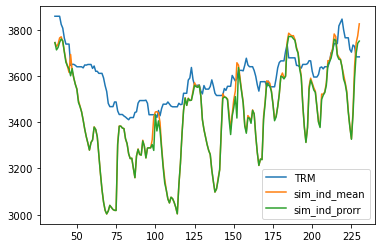

In [97]:
comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion['sim_ind_mean'].notnull()][['TRM','sim_ind_mean','sim_ind_prorr']].plot()

In [98]:
comparacionIndiceVsSimulacion[:50]

,Date,date,TRM,sim_ind_mean,sim_ind_prorr
0,2020-09-09,2020-09-09,3757.21,NaN,NaN
1,2020-09-10,2020-09-10,3717.25,NaN,NaN
2,2020-09-11,2020-09-11,3700.28,NaN,NaN
3,2020-09-12,2020-09-12,3709.00,NaN,NaN
4,2020-09-13,2020-09-13,3709.00,NaN,NaN
5,2020-09-14,2020-09-14,3709.00,NaN,NaN
6,2020-09-15,2020-09-15,3697.00,NaN,NaN
7,2020-09-16,2020-09-16,3683.49,NaN,NaN
8,2020-09-17,2020-09-17,3703.86,NaN,NaN
9,2020-09-18,2020-09-18,3714.65,NaN,NaN


In [99]:
comparacionIndiceVsSimulacion[51:100]

,Date,date,TRM,sim_ind_mean,sim_ind_prorr
51,2020-11-15,2020-11-15,3639.95,3494.218540,3485.862065
52,2020-11-16,2020-11-16,3639.95,3468.891973,3467.555918
53,2020-11-17,2020-11-17,3639.95,3445.289472,3444.491572
54,2020-11-18,2020-11-18,3635.19,3409.520558,3409.354682
55,2020-11-19,2020-11-19,3647.73,3370.063289,3370.063289
56,2020-11-20,2020-11-20,3647.10,3337.201301,3337.201301
57,2020-11-21,2020-11-21,3649.90,3309.761680,3309.761680
58,2020-11-22,2020-11-22,3649.90,3279.476647,3279.476647
59,2020-11-23,2020-11-23,3649.90,3312.386617,3312.029848
60,2020-11-24,2020-11-24,3632.92,3323.367784,3323.367784


In [100]:
comparacionIndiceVsSimulacion[101:150]

,Date,date,TRM,sim_ind_mean,sim_ind_prorr
101,2021-01-05,2021-01-05,3420.78,3445.646766,3362.221746
102,2021-01-06,2021-01-06,3450.74,3439.732305,3406.034700
103,2021-01-07,2021-01-07,3428.04,3399.471017,3364.861445
104,2021-01-08,2021-01-08,3459.39,3295.136955,3284.485438
105,2021-01-10,2021-01-10,3478.11,3214.591051,3203.909152
106,2021-01-11,2021-01-11,3478.11,3153.831638,3136.615413
107,2021-01-12,2021-01-12,3478.11,3106.287934,3106.287934
108,2021-01-13,2021-01-13,3487.65,3068.054442,3068.054442
109,2021-01-14,2021-01-14,3478.36,3050.878882,3050.878882
110,2021-01-15,2021-01-15,3469.76,3075.578288,3075.578288


## 2.  buscar ley de potencia con tabla transacciones

In [101]:
DF_TRANSACCIONES_cop

,idComprador,idVendedor,cantidadTransaccion,precioTransaccion,fechaPulso,ciclo,importe
0,31,67,5590.915717,3664.34762,36,1.0,2.048706e+07
1,75,67,177680.021575,3664.34762,36,1.0,6.510814e+08
2,44,67,78733.705732,3664.34762,36,1.0,2.885077e+08
3,3,67,81277.194116,3664.34762,36,1.0,2.978279e+08
4,79,67,52252.413031,3664.34762,36,1.0,1.914710e+08
...,...,...,...,...,...,...,...
14796,469,8,1791.817501,3850.97991,230,1.0,6.900253e+06
14797,378,8,15111.574274,3850.97991,230,1.0,5.819437e+07
14798,356,8,31083.295712,3850.97991,230,1.0,1.197011e+08
14799,386,8,172675.565883,3850.97991,230,1.0,6.649701e+08


### Análisis Compradores

<AxesSubplot:>

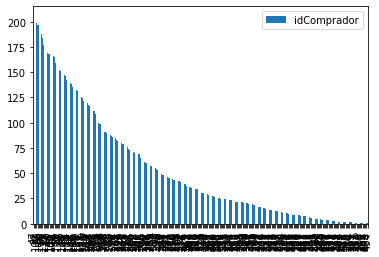

In [102]:
DF_TRANSACCIONES_cop['idComprador'].value_counts().to_frame().plot.bar()

<AxesSubplot:>

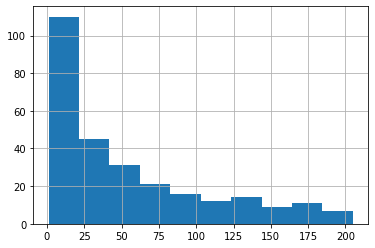

In [103]:
DF_TRANSACCIONES_cop['idComprador'].value_counts().hist()

<AxesSubplot:>

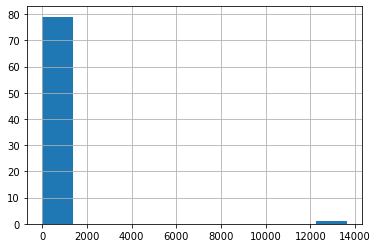

In [104]:
DF_TRANSACCIONES_cop['idVendedor'].value_counts().hist()

## Comportamiento Agentes específicos

In [105]:
df_estadoAgentes['id'].value_counts().to_frame('numTrans')

,numTrans
3,196
34,196
47,196
50,196
23,196
...,...
159,1
89,1
39,1
443,1


In [106]:
agente_longevo=df_estadoAgentes['id'].value_counts().to_frame('numTrans').index[0]
agente_longevo

3

In [107]:
#df_estadoAgentes[df_estadoAgentes['id'].isin([agente_longevo])]

In [108]:
df_estadoAgentes[df_estadoAgentes['id'].isin([agente_longevo])].set_index('pulso')

,id,TIPO,edad,capital,stockProducto,val_stock,val_empresa,ciclo
pulso,,,,,,,,
35,3,Comprador,0,3.254783e+08,36846.000000,1.421725e+08,4.627407e+16,1
36,3,Comprador,1,3.370035e+07,113314.717613,4.372316e+08,4.709320e+08,1
37,3,Comprador,2,4.995797e+07,108701.981213,4.070534e+08,4.570114e+08,1
38,3,Comprador,3,2.350456e+07,116665.710475,4.348560e+08,4.583606e+08,1
39,3,Comprador,4,4.186601e+07,111916.564198,4.183663e+08,4.602323e+08,1
...,...,...,...,...,...,...,...,...
226,3,Comprador,191,2.947793e+07,88493.024329,2.945274e+08,3.240054e+08,1
227,3,Comprador,192,4.038551e+07,84890.712087,2.926146e+08,3.330001e+08,1
228,3,Comprador,193,1.729780e+07,91687.517478,3.338335e+08,3.511313e+08,1


<AxesSubplot:xlabel='pulso'>

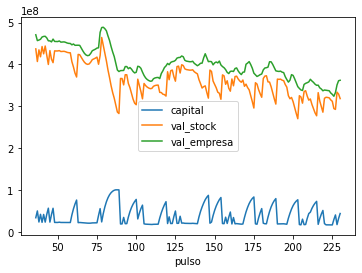

In [109]:
df_estadoAgentes[df_estadoAgentes['id'].isin([agente_longevo])].set_index('pulso')[['capital','val_stock','val_empresa']][1:].plot()

### Numero de transacciones por día

In [110]:
DF_TRANSACCIONES_cop['fechaPulso'].value_counts().to_frame('transDiarias').sort_index()

,transDiarias
36,47
37,55
38,48
39,45
40,45
...,...
226,104
227,58
228,56
229,72


<AxesSubplot:>

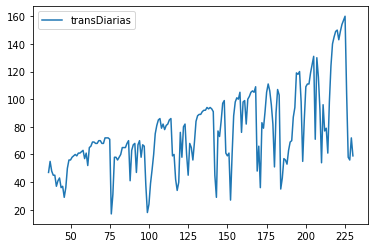

In [111]:
DF_TRANSACCIONES_cop['fechaPulso'].value_counts().to_frame('transDiarias').sort_index().plot()

In [112]:
## caracteristicas mejores agentes

In [113]:
## distribución mejores agentes en el tiempo

In [114]:
#exponente de hurst trm calculada

In [115]:
comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion.index>FECHA_INICIAL_PULSO]

,Date,date,TRM,sim_ind_mean,sim_ind_prorr
37,2020-11-01,2020-11-01,3858.56,3727.367948,3712.966868
38,2020-11-02,2020-11-02,3858.56,3738.198266,3723.381231
39,2020-11-03,2020-11-03,3858.56,3764.672165,3745.740749
40,2020-11-04,2020-11-04,3823.45,3769.667818,3760.257681
41,2020-11-05,2020-11-05,3807.13,3747.279969,3752.429466
...,...,...,...,...,...
226,2021-05-13,2021-05-13,3734.09,3446.956015,3432.248086
227,2021-05-14,2021-05-14,3728.09,3640.991963,3590.430781
228,2021-05-15,2021-05-15,3682.84,3743.097084,3696.703933
229,2021-05-16,2021-05-16,3682.84,3773.811143,3741.763059


In [116]:
from hurst import compute_Hc

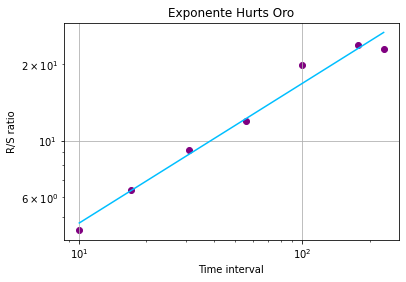

H=0.5491, c=1.3410


In [117]:
H, c, data = compute_Hc(comparacionIndiceVsSimulacion['TRM'], kind='price', simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.set_title('Exponente Hurts Oro')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

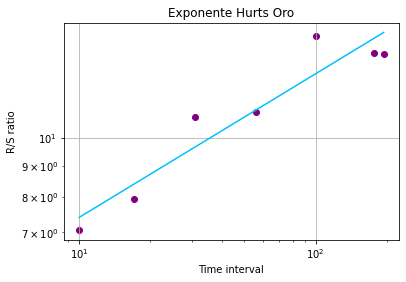

H=0.2354, c=4.3077


In [118]:
H, c, data = compute_Hc(comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion.index>FECHA_INICIAL_PULSO]['sim_ind_prorr'], kind='price', simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.set_title('Exponente Hurts Oro')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

In [119]:
comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion.index>FECHA_INICIAL_PULSO][-100:]['sim_ind_prorr']

131    3368.173690
132    3335.745163
133    3303.950131
134    3278.063805
135    3260.607446
          ...     
226    3432.248086
227    3590.430781
228    3696.703933
229    3741.763059
230    3751.072155
Name: sim_ind_prorr, Length: 100, dtype: float64

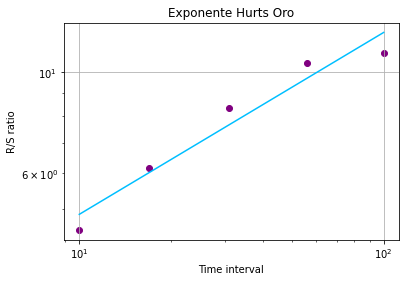

H=0.3988, c=1.9461


In [120]:
H, c, data = compute_Hc(comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion.index>FECHA_INICIAL_PULSO][-100:]['sim_ind_prorr'], kind='price', simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.set_title('Exponente Hurts Oro')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

### 3 temas
* hacer un lazo cerrado para validar si mejora el exponente de hurst
* validar los puntos más bajos de pronóstico y validar como tratarlos
* mirar las lecturas de los mejores

# Repetir con mayor complejidad

In [121]:
#252-FECHA_PULSO

In [122]:
#FECHA_INICIAL_PULSO=36
#CICLO

In [123]:
#for generacion in range(0,100,1):
for aux_ciclo in range(0,2,1):
    CICLO=CICLO+1
    print(CICLO)
    FECHA_PULSO=FECHA_INICIAL_PULSO
    VALOR_MOMENTO_INDICE=datos_trm[datos_trm['date']<=calendario.iloc[FECHA_PULSO]['Date']].iloc[-1]['TRM']
    for generacion in range(0,len(calendario)-FECHA_INICIAL_PULSO,1):
        aux_df_transacciones=DF_TRANSACCIONES[DF_TRANSACCIONES['fechaPulso']==FECHA_PULSO-1]
        if tipo_indice=='real' or generacion==0 or len(aux_df_transacciones)==0:
            VALOR_MOMENTO_INDICE=datos_trm[datos_trm['date']<=calendario.iloc[FECHA_PULSO]['Date']].iloc[-1]['TRM']
        elif tipo_indice=='emergente':            
            aux_df_transacciones['importe']=aux_df_transacciones['cantidadTransaccion']*aux_df_transacciones['precioTransaccion']
            #aux_df_transacciones['importe'].sum()/aux_df_transacciones['cantidadTransaccion'].sum()
            VALOR_MOMENTO_INDICE=aux_df_transacciones['importe'].sum()/aux_df_transacciones['cantidadTransaccion'].sum()

        POBLACION_ACTUAL=len(compradores)+len(vendedores)    
        quiebraEmpresas()# capturar información de agentes quebrados
        POBLACION_ACTUAL=len(compradores)+len(vendedores)
        print("PULSO: ",FECHA_PULSO, "Generacion: ",generacion, " poblacion actual: ",POBLACION_ACTUAL,' numero acumulado agentes: ',NUMERO_ACUMULADO_AGENTES)
        nuevosAgentes()
        #print("numCompradores: ",len(compradores), "numVendedores: ",len(vendedores))
        pronosticoUniverso()
        compradoresActivos=[]
        vendedoresActivos=[]
        activacionUniverso()
        #print("numCompradoresActivos: ",len(compradoresActivos), "numVendedoresActivos: ",len(vendedoresActivos))
        transaccionarUniverso()
        #print("numCompradoresActivos: ",len(compradoresActivos), "numVendedoresActivos: ",len(vendedoresActivos))
        vivirUniverso()
        print("numCompradores: ",len(compradores), "numVendedores: ",len(vendedores) )
        ## capturar estado empresas
        if len(compradores)>0:
            aux_df_agentC=pd.DataFrame.from_dict(compradores)[['id','TIPO','edad','capital','stockProducto']]
            aux_df_agentC['val_stock']=aux_df_agentC['stockProducto']*VALOR_MOMENTO_INDICE
            aux_df_agentC['val_empresa']=aux_df_agentC['val_stock']+aux_df_agentC['capital']
            aux_df_agentC['pulso']=FECHA_PULSO
            aux_df_agentC['ciclo']=CICLO
            df_estadoAgentes=df_estadoAgentes.append(aux_df_agentC)

        if len(vendedores)>0:
            aux_df_agentV=pd.DataFrame.from_dict(vendedores)[['id','TIPO','edad','capital','stockProducto']]
            aux_df_agentV['val_stock']=aux_df_agentV['stockProducto']*VALOR_MOMENTO_INDICE
            aux_df_agentV['val_empresa']=aux_df_agentV['val_stock']+aux_df_agentV['capital']
            aux_df_agentV['pulso']=FECHA_PULSO
            aux_df_agentV['ciclo']=CICLO
            df_estadoAgentes=df_estadoAgentes.append(aux_df_agentV)

        FECHA_PULSO=FECHA_PULSO+1

PULSO:  36 Generacion:  0  poblacion actual:  180  numero acumulado agentes:  497
max_generacion_agentes:  0.05 nuevos Agentes:  8 pob actual:  180 pob final:  188
numCompradores:  175 numVendedores:  13
PULSO:  37 Generacion:  1  poblacion actual:  183  numero acumulado agentes:  505
max_generacion_agentes:  0.05 nuevos Agentes:  5 pob actual:  183 pob final:  188
numCompradores:  177 numVendedores:  11
PULSO:  38 Generacion:  2  poblacion actual:  184  numero acumulado agentes:  510
max_generacion_agentes:  0.05 nuevos Agentes:  2 pob actual:  184 pob final:  186
numCompradores:  177 numVendedores:  9
PULSO:  39 Generacion:  3  poblacion actual:  181  numero acumulado agentes:  512
max_generacion_agentes:  0.05 nuevos Agentes:  5 pob actual:  181 pob final:  186
numCompradores:  178 numVendedores:  8
PULSO:  40 Generacion:  4  poblacion actual:  182  numero acumulado agentes:  517
max_generacion_agentes:  0.05 nuevos Agentes:  7 pob actual:  182 pob final:  189
numCompradores:  181 n

numCompradores:  267 numVendedores:  8
PULSO:  77 Generacion:  41  poblacion actual:  273  numero acumulado agentes:  735
max_generacion_agentes:  0.05 nuevos Agentes:  1 pob actual:  273 pob final:  274
numCompradores:  268 numVendedores:  6
PULSO:  78 Generacion:  42  poblacion actual:  269  numero acumulado agentes:  736
max_generacion_agentes:  0.05 nuevos Agentes:  6 pob actual:  269 pob final:  275
numCompradores:  267 numVendedores:  8
PULSO:  79 Generacion:  43  poblacion actual:  270  numero acumulado agentes:  742
max_generacion_agentes:  0.05 nuevos Agentes:  6 pob actual:  270 pob final:  276
numCompradores:  265 numVendedores:  11
PULSO:  80 Generacion:  44  poblacion actual:  273  numero acumulado agentes:  748
max_generacion_agentes:  0.05 nuevos Agentes:  2 pob actual:  273 pob final:  275
numCompradores:  265 numVendedores:  10
PULSO:  81 Generacion:  45  poblacion actual:  273  numero acumulado agentes:  750
max_generacion_agentes:  0.05 nuevos Agentes:  0 pob actual:

numCompradores:  344 numVendedores:  15
PULSO:  117 Generacion:  81  poblacion actual:  356  numero acumulado agentes:  972
max_generacion_agentes:  0.05 nuevos Agentes:  3 pob actual:  356 pob final:  359
numCompradores:  347 numVendedores:  12
PULSO:  118 Generacion:  82  poblacion actual:  358  numero acumulado agentes:  975
max_generacion_agentes:  0.05 nuevos Agentes:  3 pob actual:  358 pob final:  361
numCompradores:  350 numVendedores:  11
PULSO:  119 Generacion:  83  poblacion actual:  358  numero acumulado agentes:  978
max_generacion_agentes:  0.05 nuevos Agentes:  1 pob actual:  358 pob final:  359
numCompradores:  350 numVendedores:  9
PULSO:  120 Generacion:  84  poblacion actual:  358  numero acumulado agentes:  979
max_generacion_agentes:  0.05 nuevos Agentes:  12 pob actual:  358 pob final:  370
numCompradores:  355 numVendedores:  15
PULSO:  121 Generacion:  85  poblacion actual:  366  numero acumulado agentes:  991
max_generacion_agentes:  0.05 nuevos Agentes:  13 po

numCompradores:  494 numVendedores:  14
PULSO:  157 Generacion:  121  poblacion actual:  501  numero acumulado agentes:  1355
max_generacion_agentes:  0.05 nuevos Agentes:  22 pob actual:  501 pob final:  523
numCompradores:  501 numVendedores:  22
PULSO:  158 Generacion:  122  poblacion actual:  513  numero acumulado agentes:  1377
max_generacion_agentes:  0.05 nuevos Agentes:  0 pob actual:  513 pob final:  513
numCompradores:  496 numVendedores:  17
PULSO:  159 Generacion:  123  poblacion actual:  505  numero acumulado agentes:  1377
max_generacion_agentes:  0.05 nuevos Agentes:  12 pob actual:  505 pob final:  517
numCompradores:  498 numVendedores:  19
PULSO:  160 Generacion:  124  poblacion actual:  512  numero acumulado agentes:  1389
max_generacion_agentes:  0.05 nuevos Agentes:  18 pob actual:  512 pob final:  530
numCompradores:  508 numVendedores:  22
PULSO:  161 Generacion:  125  poblacion actual:  524  numero acumulado agentes:  1407
max_generacion_agentes:  0.05 nuevos Ag

numCompradores:  823 numVendedores:  34
PULSO:  197 Generacion:  161  poblacion actual:  842  numero acumulado agentes:  2072
max_generacion_agentes:  0.05 nuevos Agentes:  5 pob actual:  842 pob final:  847
numCompradores:  818 numVendedores:  29
PULSO:  198 Generacion:  162  poblacion actual:  835  numero acumulado agentes:  2077
max_generacion_agentes:  0.05 nuevos Agentes:  27 pob actual:  835 pob final:  862
numCompradores:  826 numVendedores:  36
PULSO:  199 Generacion:  163  poblacion actual:  851  numero acumulado agentes:  2104
max_generacion_agentes:  0.05 nuevos Agentes:  2 pob actual:  851 pob final:  853
numCompradores:  827 numVendedores:  26
PULSO:  200 Generacion:  164  poblacion actual:  844  numero acumulado agentes:  2106
max_generacion_agentes:  0.05 nuevos Agentes:  18 pob actual:  844 pob final:  862
numCompradores:  840 numVendedores:  22
PULSO:  201 Generacion:  165  poblacion actual:  856  numero acumulado agentes:  2124
max_generacion_agentes:  0.05 nuevos Age

numCompradores:  1331 numVendedores:  57
PULSO:  41 Generacion:  5  poblacion actual:  1362  numero acumulado agentes:  3200
max_generacion_agentes:  0.05 nuevos Agentes:  62 pob actual:  1362 pob final:  1424
numCompradores:  1354 numVendedores:  70
PULSO:  42 Generacion:  6  poblacion actual:  1396  numero acumulado agentes:  3262
max_generacion_agentes:  0.05 nuevos Agentes:  53 pob actual:  1396 pob final:  1449
numCompradores:  1376 numVendedores:  73
PULSO:  43 Generacion:  7  poblacion actual:  1420  numero acumulado agentes:  3315
max_generacion_agentes:  0.05 nuevos Agentes:  22 pob actual:  1420 pob final:  1442
numCompradores:  1383 numVendedores:  59
PULSO:  44 Generacion:  8  poblacion actual:  1417  numero acumulado agentes:  3337
max_generacion_agentes:  0.05 nuevos Agentes:  1 pob actual:  1417 pob final:  1418
numCompradores:  1376 numVendedores:  42
PULSO:  45 Generacion:  9  poblacion actual:  1399  numero acumulado agentes:  3338
max_generacion_agentes:  0.05 nuevos

numCompradores:  2043 numVendedores:  39
PULSO:  80 Generacion:  44  poblacion actual:  2058  numero acumulado agentes:  4745
max_generacion_agentes:  0.05 nuevos Agentes:  19 pob actual:  2058 pob final:  2077
numCompradores:  2049 numVendedores:  28
PULSO:  81 Generacion:  45  poblacion actual:  2063  numero acumulado agentes:  4764
max_generacion_agentes:  0.05 nuevos Agentes:  2 pob actual:  2063 pob final:  2065
numCompradores:  2047 numVendedores:  18
PULSO:  82 Generacion:  46  poblacion actual:  2047  numero acumulado agentes:  4766
max_generacion_agentes:  0.05 nuevos Agentes:  20 pob actual:  2047 pob final:  2067
numCompradores:  2046 numVendedores:  21
PULSO:  83 Generacion:  47  poblacion actual:  2053  numero acumulado agentes:  4786
max_generacion_agentes:  0.05 nuevos Agentes:  37 pob actual:  2053 pob final:  2090
numCompradores:  2057 numVendedores:  33
PULSO:  84 Generacion:  48  poblacion actual:  2073  numero acumulado agentes:  4823
max_generacion_agentes:  0.05 n

numCompradores:  3046 numVendedores:  134
PULSO:  119 Generacion:  83  poblacion actual:  3131  numero acumulado agentes:  6978
max_generacion_agentes:  0.05 nuevos Agentes:  42 pob actual:  3131 pob final:  3173
numCompradores:  3065 numVendedores:  108
PULSO:  120 Generacion:  84  poblacion actual:  3126  numero acumulado agentes:  7020
max_generacion_agentes:  0.05 nuevos Agentes:  95 pob actual:  3126 pob final:  3221
numCompradores:  3108 numVendedores:  113
PULSO:  121 Generacion:  85  poblacion actual:  3173  numero acumulado agentes:  7115
max_generacion_agentes:  0.05 nuevos Agentes:  66 pob actual:  3173 pob final:  3239
numCompradores:  3144 numVendedores:  95
PULSO:  122 Generacion:  86  poblacion actual:  3199  numero acumulado agentes:  7181
max_generacion_agentes:  0.05 nuevos Agentes:  51 pob actual:  3199 pob final:  3250
numCompradores:  3168 numVendedores:  82
PULSO:  123 Generacion:  87  poblacion actual:  3211  numero acumulado agentes:  7232
max_generacion_agentes

numCompradores:  4534 numVendedores:  135
PULSO:  158 Generacion:  122  poblacion actual:  4603  numero acumulado agentes:  10317
max_generacion_agentes:  0.05 nuevos Agentes:  65 pob actual:  4603 pob final:  4668
numCompradores:  4553 numVendedores:  115
PULSO:  159 Generacion:  123  poblacion actual:  4605  numero acumulado agentes:  10382
max_generacion_agentes:  0.05 nuevos Agentes:  38 pob actual:  4605 pob final:  4643
numCompradores:  4553 numVendedores:  90
PULSO:  160 Generacion:  124  poblacion actual:  4593  numero acumulado agentes:  10420
max_generacion_agentes:  0.05 nuevos Agentes:  194 pob actual:  4593 pob final:  4787
numCompradores:  4657 numVendedores:  130
PULSO:  161 Generacion:  125  poblacion actual:  4735  numero acumulado agentes:  10614
max_generacion_agentes:  0.05 nuevos Agentes:  66 pob actual:  4735 pob final:  4801
numCompradores:  4674 numVendedores:  127
PULSO:  162 Generacion:  126  poblacion actual:  4744  numero acumulado agentes:  10680
max_genera

numCompradores:  7552 numVendedores:  286
PULSO:  196 Generacion:  160  poblacion actual:  7728  numero acumulado agentes:  16768
max_generacion_agentes:  0.05 nuevos Agentes:  207 pob actual:  7728 pob final:  7935
numCompradores:  7660 numVendedores:  275
PULSO:  197 Generacion:  161  poblacion actual:  7817  numero acumulado agentes:  16975
max_generacion_agentes:  0.05 nuevos Agentes:  347 pob actual:  7817 pob final:  8164
numCompradores:  7837 numVendedores:  327
PULSO:  198 Generacion:  162  poblacion actual:  8031  numero acumulado agentes:  17322
max_generacion_agentes:  0.05 nuevos Agentes:  233 pob actual:  8031 pob final:  8264
numCompradores:  7942 numVendedores:  322
PULSO:  199 Generacion:  163  poblacion actual:  8134  numero acumulado agentes:  17555
max_generacion_agentes:  0.05 nuevos Agentes:  6 pob actual:  8134 pob final:  8140
numCompradores:  7915 numVendedores:  225
PULSO:  200 Generacion:  164  poblacion actual:  8029  numero acumulado agentes:  17561
max_gene

KeyboardInterrupt: 

## Validacion resultado

In [124]:
DF_TRANSACCIONES

,idComprador,idVendedor,cantidadTransaccion,precioTransaccion,fechaPulso,ciclo
0,31.0,67.0,5590.915717,3664.347620,36.0,1.0
1,75.0,67.0,177680.021575,3664.347620,36.0,1.0
2,44.0,67.0,78733.705732,3664.347620,36.0,1.0
3,3.0,67.0,81277.194116,3664.347620,36.0,1.0
4,79.0,67.0,52252.413031,3664.347620,36.0,1.0
...,...,...,...,...,...,...
891154,9843.0,754.0,11021.176577,2836.066978,36.0,4.0
891155,1383.0,754.0,58586.924561,2836.066978,36.0,4.0
891156,17999.0,754.0,36104.404314,2836.066978,36.0,4.0
891157,23498.0,754.0,65232.305622,2836.066978,36.0,4.0


In [125]:
DF_TRANSACCIONES_cop=DF_TRANSACCIONES.copy()
DF_TRANSACCIONES_cop['importe']=DF_TRANSACCIONES_cop['cantidadTransaccion']*DF_TRANSACCIONES_cop['precioTransaccion']
#DF_TRANSACCIONES_cop.index=DF_TRANSACCIONES_cop.index.astype(int)
DF_TRANSACCIONES_cop['idComprador']=DF_TRANSACCIONES_cop['idComprador'].astype(int)
DF_TRANSACCIONES_cop['idVendedor']=DF_TRANSACCIONES_cop['idVendedor'].astype(int)
DF_TRANSACCIONES_cop['fechaPulso']=DF_TRANSACCIONES_cop['fechaPulso'].astype(int)

In [126]:
indice_simulacion=DF_TRANSACCIONES_cop[['ciclo','fechaPulso','precioTransaccion','cantidadTransaccion','importe']].groupby(['fechaPulso','ciclo']).agg(['mean','sum'])
indice_simulacion

precioTransaccion               cantidadTransaccion  \
                              mean           sum                mean   
fechaPulso ciclo                                                       
36         1.0         3744.344157  1.759842e+05        5.853762e+04   
           2.0         3799.566149  4.939436e+05        7.776820e+05   
           3.0         2836.066978  2.932493e+06        3.268237e+08   
           4.0         2836.066978  2.229149e+06        1.131027e+09   
37         1.0         3712.966868  2.042132e+05        6.791783e+04   
...                            ...           ...                 ...   
229        2.0         2853.903606  3.330506e+06        3.479967e+08   
           3.0         2853.263846  2.840424e+07        1.852585e+13   
230        1.0         3751.072155  2.213133e+05        3.269258e+05   
           2.0         2821.576079  3.419750e+06        3.544152e+08   
           3.0         2820.789952  2.869025e+07        1.939752e+13   

                                     importe                
                           sum          mean           sum  
fechaPulso ciclo                                            
36         1.0    2.751268e+06  2.192043e+08  1.030260e+10  
           2.0    1.010987e+08  2.961163e+09  3.849511e+11  
           3.0    3.379357e+11  9.268939e+11  9.584083e+14  
           4.0    8.889868e+11  3.207667e+12  2.521226e+15  
37         1.0    3.735480e+06  2.531547e+08  1.392351e+10  
...                        ...           ...           ...  
229        2.0    4.061122e+11  9.931728e+11  1.159033e+15  
           3.0    1.844249e+17  5.287025e+16  5.263233e+20  
230        1.0    1.928862e+07  1.250711e+09  7.379198e+10  
           2.0    4.295512e+11  1.000130e+12  1.212157e+15  
           3.0    1.972922e+17  5.473607e+16  5.567206e+20  

[586 rows x 6 columns]

In [127]:
indice_simulacion.columns = indice_simulacion.columns.map('|'.join).str.strip('|')
indice_simulacion['indiceProrr']=indice_simulacion['importe|sum']/indice_simulacion['cantidadTransaccion|sum']
indice_simulacion=indice_simulacion[['indiceProrr','precioTransaccion|mean']]
indice_simulacion.columns=['sim_ind_mean','sim_ind_prorr']
indice_simulacion

sim_ind_mean  sim_ind_prorr
fechaPulso ciclo                             
36         1.0     3744.673264    3744.344157
           2.0     3807.677707    3799.566149
           3.0     2836.066978    2836.066978
           4.0     2836.066978    2836.066978
37         1.0     3727.367948    3712.966868
...                        ...            ...
229        2.0     2853.971463    2853.903606
           3.0     2853.863340    2853.263846
230        1.0     3825.674019    3751.072155
           2.0     2821.915461    2821.576079
           3.0     2821.807214    2820.789952

[586 rows x 2 columns]

In [128]:
indice_simulacion=indice_simulacion[['sim_ind_prorr']].reset_index()

In [129]:
indice_simulacion

,fechaPulso,ciclo,sim_ind_prorr
0,36,1.0,3744.344157
1,36,2.0,3799.566149
2,36,3.0,2836.066978
3,36,4.0,2836.066978
4,37,1.0,3712.966868
...,...,...,...
581,229,2.0,2853.903606
582,229,3.0,2853.263846
583,230,1.0,3751.072155
584,230,2.0,2821.576079


In [130]:
indice_simulacion=pd.pivot_table(indice_simulacion, index=['fechaPulso'], columns=['ciclo'],values='sim_ind_prorr').reset_index()

In [131]:
comparacionIndiceVsSimulacion=calendario.merge(datos_trm[['date','TRM']], left_on='Date', right_on='date', how='left')

In [132]:
indice_simulacion

ciclo,fechaPulso,1.0,2.0,3.0,4.0
0,36,3744.344157,3799.566149,2836.066978,2836.066978
1,37,3712.966868,3771.676769,2325.275879,NaN
2,38,3723.381231,3726.119168,2104.133743,NaN
3,39,3745.740749,3663.364144,2120.404142,NaN
4,40,3760.257681,3565.623353,2185.968123,NaN
...,...,...,...,...,...
190,226,3432.248086,2829.030961,2828.476815,NaN
191,227,3590.430781,2857.710239,2856.973456,NaN
192,228,3696.703933,2850.762525,2850.289122,NaN
193,229,3741.763059,2853.903606,2853.263846,NaN


In [133]:
comparacionIndiceVsSimulacion=comparacionIndiceVsSimulacion.merge(indice_simulacion, left_index=True, right_on='fechaPulso', how='left')

In [134]:
comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion['fechaPulso']>=36]

,Date,date,TRM,fechaPulso,1.0,2.0,3.0,4.0
0.0,2020-10-31,2020-10-31,3858.56,36,3744.344157,3799.566149,2836.066978,2836.066978
1.0,2020-11-01,2020-11-01,3858.56,37,3712.966868,3771.676769,2325.275879,NaN
2.0,2020-11-02,2020-11-02,3858.56,38,3723.381231,3726.119168,2104.133743,NaN
3.0,2020-11-03,2020-11-03,3858.56,39,3745.740749,3663.364144,2120.404142,NaN
4.0,2020-11-04,2020-11-04,3823.45,40,3760.257681,3565.623353,2185.968123,NaN
...,...,...,...,...,...,...,...,...
190.0,2021-05-13,2021-05-13,3734.09,226,3432.248086,2829.030961,2828.476815,NaN
191.0,2021-05-14,2021-05-14,3728.09,227,3590.430781,2857.710239,2856.973456,NaN
192.0,2021-05-15,2021-05-15,3682.84,228,3696.703933,2850.762525,2850.289122,NaN
193.0,2021-05-16,2021-05-16,3682.84,229,3741.763059,2853.903606,2853.263846,NaN


<AxesSubplot:>

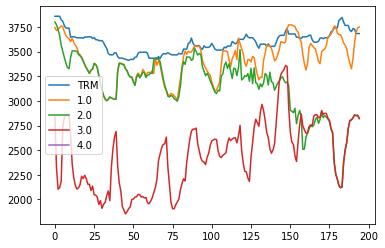

In [135]:
comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion['fechaPulso']>=36][['TRM',1,2,3,4]].plot()

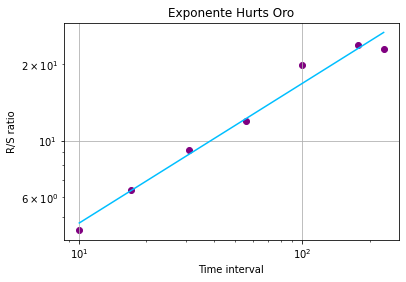

H=0.5491, c=1.3410


In [136]:
H, c, data = compute_Hc(comparacionIndiceVsSimulacion['TRM'], kind='price', simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.set_title('Exponente Hurts Oro')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

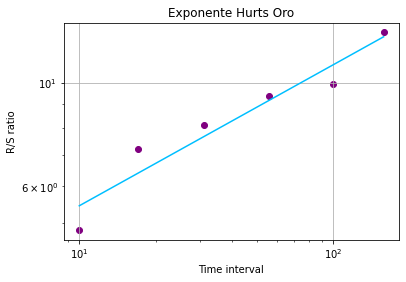

H=0.3015, c=2.7236


In [137]:
H, c, data = compute_Hc(comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion.index>FECHA_INICIAL_PULSO][1], kind='price', simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.set_title('Exponente Hurts Oro')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

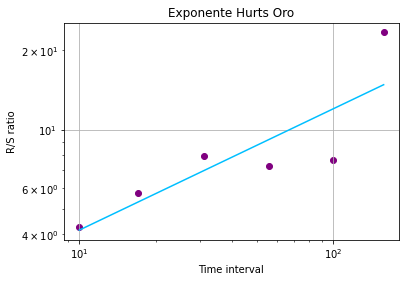

H=0.4606, c=1.4388


In [138]:
H, c, data = compute_Hc(comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion.index>FECHA_INICIAL_PULSO][2], kind='price', simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.set_title('Exponente Hurts Oro')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

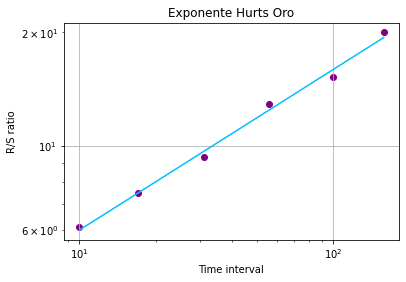

H=0.4261, c=2.2411


In [139]:
H, c, data = compute_Hc(comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion.index>FECHA_INICIAL_PULSO][3], kind='price', simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.set_title('Exponente Hurts Oro')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

In [140]:
H, c, data = compute_Hc(comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion.index>FECHA_INICIAL_PULSO][4], kind='price', simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.set_title('Exponente Hurts Oro')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

ValueError: Series contains NaNs

<AxesSubplot:>

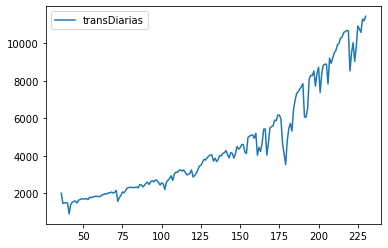

In [141]:
DF_TRANSACCIONES_cop['fechaPulso'].value_counts().to_frame('transDiarias').sort_index().plot()

<AxesSubplot:>

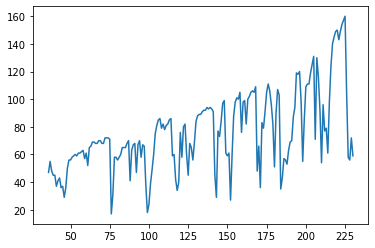

In [142]:
#DF_TRANSACCIONES_cop[DF_TRANSACCIONES_cop['ciclo']==1].value_counts().to_frame('transDiarias').sort_index().plot()
DF_TRANSACCIONES_cop[DF_TRANSACCIONES_cop['ciclo']==1]['fechaPulso'].value_counts().sort_index().plot()

<AxesSubplot:>

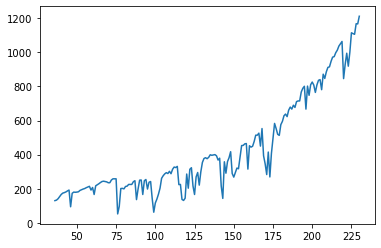

In [143]:
DF_TRANSACCIONES_cop[DF_TRANSACCIONES_cop['ciclo']==2]['fechaPulso'].value_counts().sort_index().plot()

<AxesSubplot:>

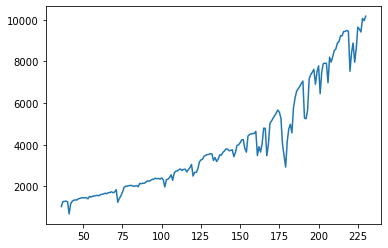

In [144]:
DF_TRANSACCIONES_cop[DF_TRANSACCIONES_cop['ciclo']==3]['fechaPulso'].value_counts().sort_index().plot()

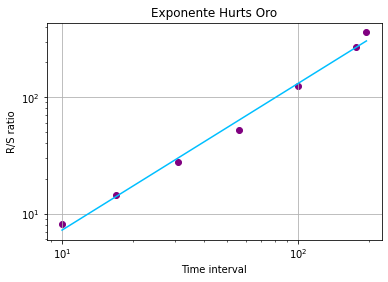

H=1.2601, c=0.3958


In [154]:
H, c, data = compute_Hc(DF_TRANSACCIONES_cop[DF_TRANSACCIONES_cop['ciclo']==1]['fechaPulso'].value_counts(), kind='price', simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.set_title('Exponente Hurts Oro')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

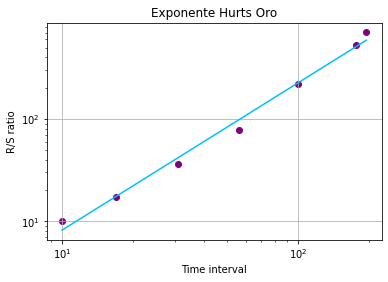

H=1.4413, c=0.2955


In [146]:
H, c, data = compute_Hc(DF_TRANSACCIONES_cop[DF_TRANSACCIONES_cop['ciclo']==2]['fechaPulso'].value_counts(), kind='price', simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.set_title('Exponente Hurts Oro')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

### Guardar resultados Parciales

In [147]:
path='resultadoTRM2'

In [148]:
DF_TRANSACCIONES_cop.to_csv(path+'/DF_TRANSACCIONES_cop.csv')

In [149]:
comparacionIndiceVsSimulacion.to_csv(path+'/comparacionIndiceVsSimulacion.csv')

In [150]:
pd.DataFrame.from_dict(agentesQuebrados).to_csv(path+'/agentesQuebrados.csv')

In [151]:
df_estadoAgentes.to_csv(path+'/df_estadoAgentes.csv')

# RECORTES

In [ ]:
## Validación  transacciones

In [ ]:
generacion=0

In [ ]:
aux_df_transacciones=DF_TRANSACCIONES[DF_TRANSACCIONES['fechaPulso']==FECHA_PULSO-1]
aux_df_transacciones

In [ ]:
if tipo_indice=='real' or generacion==0 or len(aux_df_transacciones)==0:
    print('trm real')
    VALOR_MOMENTO_INDICE=datos_trm[datos_trm['date']<=calendario.iloc[FECHA_PULSO]['Date']].iloc[-1]['TRM']

In [ ]:
FECHA_PULSO

In [ ]:
VALOR_MOMENTO_INDICE

In [ ]:
POBLACION_ACTUAL=len(compradores)+len(vendedores) 
POBLACION_ACTUAL

In [ ]:
quiebraEmpresas()

In [ ]:
POBLACION_ACTUAL=len(compradores)+len(vendedores) 
POBLACION_ACTUAL

In [ ]:
nuevosAgentes()

In [ ]:
POBLACION_ACTUAL=len(compradores)+len(vendedores) 
POBLACION_ACTUAL

In [ ]:
pronosticoUniverso()

In [ ]:
### validar pronosticos 
val_pron_compradores=pd.DataFrame.from_dict(compradores)
#val_pron_compradores

In [ ]:
val_pron_compradores['pronosticos_dia_siguiente'].describe()

In [ ]:
val_pron_vendedores=pd.DataFrame.from_dict(vendedores)
val_pron_vendedores['pronosticos_dia_siguiente'].describe()

In [ ]:
compradoresActivos=[]
vendedoresActivos=[]

In [ ]:
activacionUniverso()

In [ ]:
print("numCompradoresActivos: ",len(compradoresActivos), "numVendedoresActivos: ",len(vendedoresActivos))

In [ ]:
val_pron_compradores=pd.DataFrame.from_dict(compradores)
val_pron_compradores['precioNegociacion'].describe()

In [ ]:
val_pron_vendedores=pd.DataFrame.from_dict(vendedores)
val_pron_vendedores['precioNegociacion'].describe()

In [ ]:
#fin validación transacciones

# nuevo sistema de agentes

In [ ]:
*  solu uno universo
*  precio de neg igual al ultimo oficial
* se calcular vend y comp activos según estado
* qutar variables clientes 